## Reconhecimento Facial com Metric Learning e Máscaras Faciais

### Introdução
O reconhecimento facial é um dos desafios mais importantes no campo do Machine Learning. Inicialmente, os modelos eram treinados como classificadores, onde cada pessoa era tratada como uma classe única. No entanto, essa abordagem tinha uma grande limitação: sempre que uma nova pessoa era adicionada ao banco de dados, o modelo precisava ser re-treinado, tornando a escalabilidade do sistema inviável.

Para contornar esse problema, surgiu o **Aprendizado de Métrica** (*Metric Learning*), uma abordagem que permite que o modelo aprenda uma métrica de similaridade entre faces. Em vez de classificar indivíduos diretamente, o modelo gera vetores descritivos (*embeddings*) que representam as características únicas de cada face. Esse método permite a inclusão de novas pessoas no banco de dados sem a necessidade de re-treinamento do modelo.

No entanto, com a pandemia da COVID-19, o uso de máscaras faciais afetou significativamente os sistemas de reconhecimento facial, pois cobrem parte das características essenciais utilizadas pelos modelos para gerar os vetores descritivos. Dessa forma, novas soluções precisaram ser desenvolvidas para melhorar a precisão do reconhecimento facial em indivíduos que usam máscaras.

### Objetivo da Tarefa
Nesta atividade, vamos abordar esse problema seguindo os seguintes passos:

1. **Treinar um modelo de rede neural** utilizando um conjunto de dados com imagens de diversas celebridades.
2. **Criar um banco de dados** contendo os vetores descritivos (*embeddings*) gerados pelo modelo para cada celebridade.
3. **Incluir uma nova pessoa no banco de dados**, extraindo o vetor descritivo de sua imagem.
4. **Realizar o reconhecimento facial** dessa pessoa enquanto ela estiver usando uma máscara, verificando se o modelo é capaz de identificá-la corretamente.

Com essa abordagem, exploraremos os desafios do reconhecimento facial em cenários reais e a importância do *Metric Learning* para criar sistemas mais flexíveis e escaláveis.


# Instalando dependências

In [3]:
!pip install wordcloud matplotlib nltk

In [6]:
!pip install torch

   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 1.0/199.4 MB 8.4 MB/s eta 0:00:24
   - -------------------------------------- 7.9/199.4 MB 28.6 MB/s eta 0:00:07
   - -------------------------------------- 9.4/199.4 MB 17.8 MB/s eta 0:00:11
   -- ------------------------------------- 11.3/199.4 MB 15.6 MB/s eta 0:00:13
   -- ------------------------------------- 12.8/199.4 MB 13.9 MB/s eta 0:00:14
   -- ------------------------------------- 14.4/199.4 MB 12.6 MB/s eta 0:00:15
   --- ------------------------------------ 16.0/199.4 MB 11.7 MB/s eta 0:00:16
   --- ------------------------------------ 19.7/199.4 MB 12.8 MB/s eta 0:00:15
   ---- ----------------------------------- 22.8/199.4 MB 12.8 MB/s eta 0:00:14
   ----- ---------------------------------- 28.6/199.4 MB 14.6 MB/s eta 0:00:12
   ------- -------------------------------- 39.8/199.4 MB 18.1 MB/s eta 0:00:09
   ---------- ----------------------------- 51.6/199.

In [8]:
!pip install torchvision

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 8.2 MB/s eta 0:00:00


# Importando bibliotecas



In [9]:
import os

#descompactação
import zipfile

# manipulação de dados
import pandas as pd
import json

# gráficos
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import matplotlib.image as mpimg

# machine learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
import random

# avaliação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

# utils
import requests
from tqdm import tqdm
from scipy.spatial.distance import cosine

# processamento de linguagem natural
import nltk
from collections import Counter
import re
from nltk.util import ngrams

#downloads
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...


True

# Descompactando dados

In [23]:
folder_path = 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/post-processed.zip'
extract_path = 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/'


In [24]:
# Extrair o conteúdo do ZIP para uma nova pasta
with zipfile.ZipFile(folder_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arquivos extraídos para:", extract_path)

Arquivos extraídos para: C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/


A extração possibilita o acesso e manipulação da base de dados de imagens, que já estão processadas

In [32]:
dataset_path = extract_path+'post-processed'

# Visualizando estrutura dos dados

In [67]:
# Listar todas as pastas dentro da pasta "dataset"
all_folders = os.listdir(dataset_path)
print("10 exemplos de conteúdos da pasta:", all_folders[:10])

10 exemplos de conteúdos da pasta: ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah']


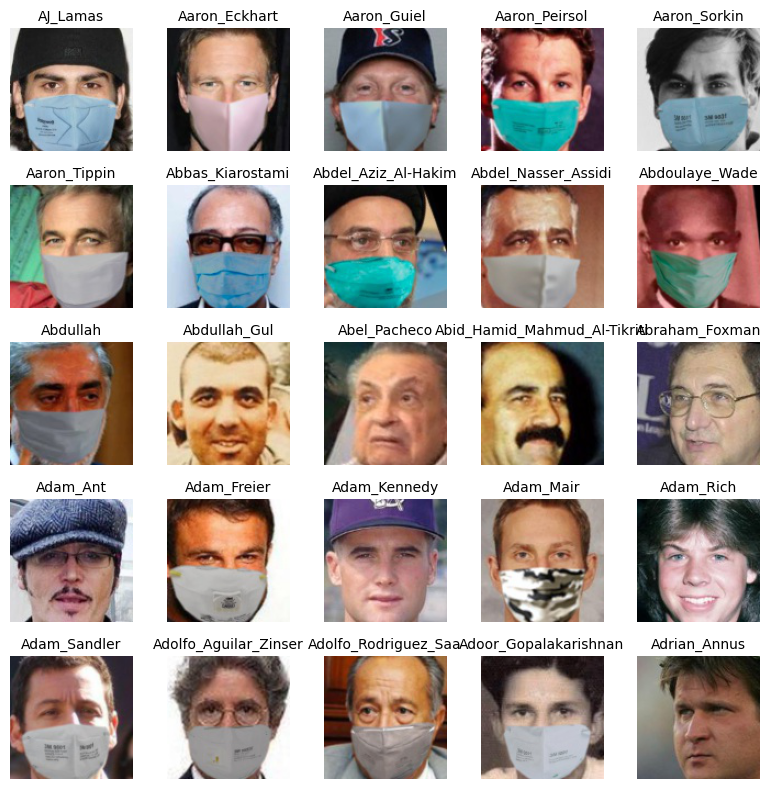

In [47]:
# Listar as primeiras 25 pastas (nomes dos famosos)
celebrity_folders = sorted(os.listdir(dataset_path))[:25]

# Criar uma figura 8x8 com subplots de 5x5
fig, axes = plt.subplots(5, 5, figsize=(8, 8))

# Iterar sobre as primeiras 25 pastas
for idx, folder in enumerate(celebrity_folders):
    folder_path = os.path.join(dataset_path, folder)

    # Listar imagens na pasta e selecionar uma aleatória
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    image_path = os.path.join(folder_path, random.choice(image_files))  # Escolhe uma imagem aleatória da pasta
    
    # Carregar imagem com PIL
    img = Image.open(image_path)  # Mantém a imagem no formato original
    
    # Plotar a imagem na grid
    row, col = divmod(idx, 5)  # Calcula a linha e a coluna
    axes[row, col].imshow(img)  # PIL já carrega no formato correto
    axes[row, col].axis("off")  # Remove eixos
    axes[row, col].set_title(folder, fontsize=10)  # Define o título como o nome da pasta (celebridade)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

In [62]:
# Criando uma lista com o nome de todos as celebridades
labels = [fname for fname in os.listdir(dataset_path)]
print(labels[:30])

['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah_Gul', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abraham_Foxman', 'Adam_Ant', 'Adam_Freier', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_Murrell', 'Adrian_Nastase', 'Adrien_Brody', 'Afton_Smith', 'Agnelo_Queiroz']


In [52]:
# Função para listar todas as pastas recursivamente
def listar_subpastas(path):
    subfolders = []
    for root, dirs, files in os.walk(path):  # Walk percorre a estrutura de pastas
        for dir_name in dirs:
            subfolders.append(os.path.join(root, dir_name))  # Adiciona o caminho completo da subpasta
    return subfolders

# Chamar a função para listar as subpastas
folders = listar_subpastas(dataset_path)


In [64]:
print(folders[:10])

['C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Eckhart', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Guiel', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Peirsol', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Sorkin', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Tippin', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Abbas_Kiarostami', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Abdel_Aziz_Al-Hakim', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-proce

In [65]:
print(str(len(folders)) + ' , ' + str(len(labels)))

2996 , 2996


## Processamento de linguagem natural

In [ ]:
print(folders)

In [ ]:
# Extrair apenas os nomes das pastas (sem o caminho completo)
folder_names = [os.path.basename(f) for f in folders]

In [ ]:
# Limpar os nomes das pastas
def clean_folder_name(name):
    # Substituir "-" por espaço
    name = name.replace("-", " ")
    # Substituir caracteres especiais por espaços
    name = re.sub(r'[^A-Za-z0-9\s]', ' ', name)
    return name

# Limpar todos os nomes das pastas
cleaned_folder_names = [clean_folder_name(name) for name in folder_names]

# Gerar uma lista com todos os nomes das pastas (para usar como base para bigramas)
folders_text = ' '.join(cleaned_folder_names)



In [ ]:
#cleaned_folder_names.remove('post processed')

print(cleaned_folder_names)

In [ ]:
# Gerar uma lista com todos os nomes das pastas (para usar como base para bigramas)
folders_text = ' '.join(cleaned_folder_names)

# Remover o prefixo 'post processed' e o espaço
folders_text = re.sub(r'^post processed\s+', '', folders_text)

print(folders_text)

In [ ]:
# Tokenizar os nomes das pastas
tokens = nltk.word_tokenize(folders_text)

# Gerar bigramas a partir dos tokens
bigrams = list(ngrams(tokens, 2))

# Contar a frequência dos bigramas
bigram_freq = Counter(bigrams)

In [ ]:
print(bigram_freq)

### Word Clouds

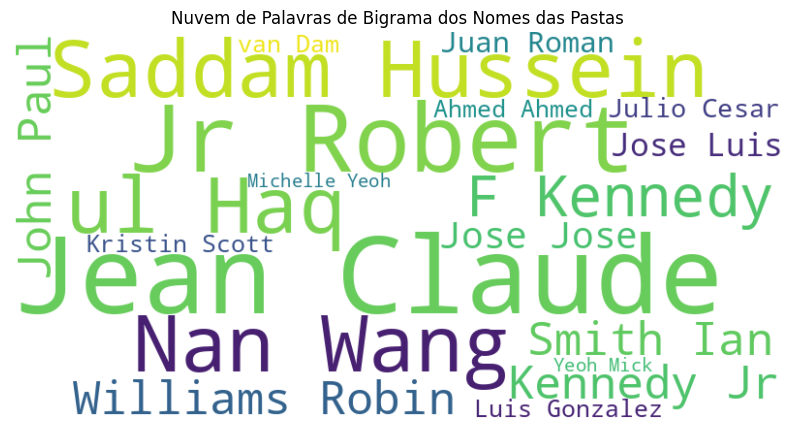

In [ ]:
# Preparar os bigramas para gerar a nuvem de palavras
bigram_freq_str = {f"{bigram[0]} {bigram[1]}": freq for bigram, freq in bigram_freq.items()}

# Criar a nuvem de palavras
wordcloud = WordCloud(max_words=20, width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_str)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remover os eixos
plt.title('Nuvem de Palavras de Bigrama dos Nomes das Pastas')
plt.show()

# Pytorch



In [68]:
dataset = datasets.ImageFolder(root=dataset_path)

In [69]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [70]:
print("Total de imagens carregadas:", len(dataset))


Total de imagens carregadas: 12000


In [71]:
# Criar dicionário {classe: lista de índices}
label_to_idx = {}
for idx, (_, label) in enumerate(dataset.samples):
    if label not in label_to_idx:
        label_to_idx[label] = []
    label_to_idx[label].append(idx)

In [72]:
# Exibir as classes e seus índices
print("Classes e seus índices:", label_to_idx)

Classes e seus índices: {0: [0, 1], 1: [2, 3, 4, 5, 6, 7], 2: [8, 9], 3: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 4: [22, 23, 24, 25], 5: [26, 27], 6: [28, 29], 7: [30, 31], 8: [32, 33], 9: [34, 35, 36, 37, 38], 10: [39, 40], 11: [41, 42, 43, 44], 12: [45, 46, 47, 48, 49, 50, 51, 52, 53], 13: [54, 55, 56, 57, 58], 14: [59, 60], 15: [61, 62, 63, 64, 65], 16: [66, 67], 17: [68, 69, 70], 18: [71, 72, 73, 74], 19: [75, 76], 20: [77, 78, 79, 80], 21: [81, 82, 83, 84, 85, 86, 87, 88, 89], 22: [90, 91, 92, 93], 23: [94, 95], 24: [96, 97, 98], 25: [99, 100], 26: [101, 102, 103, 104], 27: [105, 106], 28: [107, 108, 109, 110, 111, 112], 29: [113, 114], 30: [115, 116, 117, 118], 31: [119, 120], 32: [121, 122, 123, 124, 125, 126, 127, 128], 33: [129, 130, 131, 132, 133], 34: [134, 135, 136, 137, 138], 35: [139, 140], 36: [141, 142], 37: [143, 144], 38: [145, 146], 39: [147, 148, 149, 150], 40: [151, 152, 153, 154, 155, 156, 157, 158, 159], 41: [160, 161, 162, 163, 164], 42: [165, 166], 43

In [73]:
# Verificar o número de imagens por classe
for label, indices in label_to_idx.items():
    print(f"Classe {label} tem {len(indices)} imagens")

Classe 0 tem 2 imagens
Classe 1 tem 6 imagens
Classe 2 tem 2 imagens
Classe 3 tem 12 imagens
Classe 4 tem 4 imagens
Classe 5 tem 2 imagens
Classe 6 tem 2 imagens
Classe 7 tem 2 imagens
Classe 8 tem 2 imagens
Classe 9 tem 5 imagens
Classe 10 tem 2 imagens
Classe 11 tem 4 imagens
Classe 12 tem 9 imagens
Classe 13 tem 5 imagens
Classe 14 tem 2 imagens
Classe 15 tem 5 imagens
Classe 16 tem 2 imagens
Classe 17 tem 3 imagens
Classe 18 tem 4 imagens
Classe 19 tem 2 imagens
Classe 20 tem 4 imagens
Classe 21 tem 9 imagens
Classe 22 tem 4 imagens
Classe 23 tem 2 imagens
Classe 24 tem 3 imagens
Classe 25 tem 2 imagens
Classe 26 tem 4 imagens
Classe 27 tem 2 imagens
Classe 28 tem 6 imagens
Classe 29 tem 2 imagens
Classe 30 tem 4 imagens
Classe 31 tem 2 imagens
Classe 32 tem 8 imagens
Classe 33 tem 5 imagens
Classe 34 tem 5 imagens
Classe 35 tem 2 imagens
Classe 36 tem 2 imagens
Classe 37 tem 2 imagens
Classe 38 tem 2 imagens
Classe 39 tem 4 imagens
Classe 40 tem 9 imagens
Classe 41 tem 5 imagens
C

# KNN

In [ ]:
# Carregar o modelo ResNet pré-treinado e modificar a última camada
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Identity()  # Retirando a camada final para obter embeddings

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Remover a última camada de classificação para obter os embeddings
resnet = nn.Sequential(*list(resnet.children())[:-1])

In [ ]:
# Transformações para ajustar as imagens para o modelo
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
#código acima demorou 22 min

In [ ]:
dataset = datasets.ImageFolder(root=shared_folder_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
print(embeddings)

[0.5137753  0.23472282 0.93146515 ... 0.50376149 0.13688203 0.09544099]


In [ ]:
# Prever as classes para imagens não rotuladas ou para novos dados
predictions = knn.predict(embeddings)

In [ ]:
print(predictions)

[9 5 9 7 0 0 4 4 0 4 7 9 0 3 1 9 0 0 1 5 7 5 0 7 7 0 9 0 9 9 0 3 0 5 1 1 2
 0 1 0 5 0 3 5 3 5 1 9 9 5 3 9 5 1 0 9 0 2 1 3 1 0 2 0 0 0 5 3 0 2 5 0 5 0
 9 2 2 9 9 4 3 3 5 1 0 0 1 0 3 5 5 6 0 6 1 1 1 0 1 0]


# Neural Network

In [ ]:
# Carregar modelo pré-treinado
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 128)  # Modificando a última camada para gerar embeddings de 128 dimensões

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

In [ ]:
# Função Triplet Loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.relu(pos_dist - neg_dist + margin)
    return loss.mean()

In [ ]:
# Definir otimizador
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

# Transformações para ajuste das imagens
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Carregar o dataset
dataset = datasets.ImageFolder(root=shared_folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Inicializando as listas para armazenar as predições
y_base = []  # Lista para as predições do KNN
y_pred = []  # Lista para as predições da rede neural

# Iterando sobre cada amostra do conjunto de dados
for i in range(len(X_test)):
    # Fazendo a predição com o KNN para a amostra i
    knn_prediction = knn.predict([X_test[i]])[0]  # KNN predições para a amostra i
    y_base.append(knn_prediction)

    # Fazendo a predição com a rede neural para a amostra i
    nn_prediction = knn.predict([X_test[i]])[0]  # Rede Neural predições para a amostra i
    nn_class = np.argmax(nn_prediction)  # Obtendo a classe com maior probabilidade
    y_pred.append(nn_class)

# Agora temos as listas y_base e y_pred com as predições de KNN e Rede Neural, respectivamente

# Binarizar as predições
y_base_bin = label_binarize(y_base, classes=np.unique(y_base))  # Binariza os rótulos reais
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_pred))  # Binariza as predições

# Aqui você pode calcular métricas de avaliação como Acurácia, Recall, Precision, F1, etc.

In [ ]:
# Redimensionando a entrada para 2D
embedding = embedding.reshape(1, -1)  # Transformando para (1, n_features)

# Previsão com KNN (assumindo que KNN já foi treinado)
knn_prediction = knn.predict(embedding)  # Usando a âncora para predição
y_base_list.append(knn_prediction[0])

In [ ]:
print(y_base_list)

[9, 9]


In [ ]:
print(len(y_pred))

100


# Rede neural pré-treinada

In [ ]:
# Supondo que embeddings seja a variável com os vetores de características e labels os rótulos
X = embeddings  # Embeddings são as características extraídas das imagens
y = labels      # Labels são os rótulos das imagens

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1️⃣ Carregar modelo pré-treinado para gerar embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove a última camada para obter embeddings
resnet = resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 5️⃣ Criar dicionário {classe: lista de índices}
label_to_idx = {}
for idx, label in enumerate(labels):
    if label not in label_to_idx:
        label_to_idx[label] = []
    label_to_idx[label].append(idx)

In [ ]:
# Verificar o número de classes disponíveis
num_classes = len(label_to_idx)
print(f"Total de classes: {num_classes}")

Total de classes: 10


In [ ]:
# Converter listas para arrays NumPy (mais rápido para buscas aleatórias)
for label in label_to_idx:
    label_to_idx[label] = np.array(label_to_idx[label])

In [ ]:
# Gerar triplas (âncora, positivo, negativo) de forma otimizada
triplets = []

In [ ]:
# Criar label_to_idx
label_to_idx = {}
for idx, (_, label) in enumerate(dataset.samples):
    if label not in label_to_idx:
        label_to_idx[label] = []
    label_to_idx[label].append(idx)

In [ ]:
# Verifique se o rótulo está no label_to_idx
for _, label in dataset.samples:
    if label not in label_to_idx:
        print(f"Rótulo {label} não encontrado em label_to_idx")

In [ ]:
# Gerar triplas
triplets = []
for anchor_idx, (_, anchor_label) in enumerate(dataset.samples):
    # Selecionar positivo (mesma classe da âncora)
    if anchor_label not in label_to_idx:
        continue  # Pula caso o rótulo não esteja no dicionário

    pos_indices = label_to_idx[anchor_label]
    if len(pos_indices) < 2:
        continue  # Pula classes que não têm pelo menos 2 exemplos

    pos_idx = np.random.choice(pos_indices)
    while pos_idx == anchor_idx:
        pos_idx = np.random.choice(pos_indices)

    # Selecionar negativo (classe diferente da âncora)
    neg_labels = list(set(label_to_idx.keys()) - {anchor_label})
    neg_label = random.choice(neg_labels)
    neg_idx = np.random.choice(label_to_idx[neg_label])

    # Adicionar tripla à lista
    triplets.append((anchor_idx, pos_idx, neg_idx))

# Mostrar estatísticas
print(f"Total de triplas geradas: {len(triplets)}")

Total de triplas geradas: 11990


In [ ]:
print(triplets)

# Criando banco de dados

In [ ]:
# Caminho para salvar o banco de dados
database_path = "face_database.pkl"


In [ ]:
# Criar o banco de dados
face_database = {}

In [ ]:
def get_embeddings(model, data_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    embeddings = []

    with torch.no_grad():  # Não precisa de gradientes
        for inputs, _ in data_loader:  # Supondo que data_loader seja um iterador de batchs
            # Passa os inputs pela rede
            x = inputs.cuda()  # Mover para GPU se necessário
            feature = model(x)  # Pega as saídas (embeddings)
            embeddings.append(feature.cpu().numpy())  # Armazena os embeddings no CPU (converte para numpy)

    return np.concatenate(embeddings, axis=0)  # Concatenar os embeddings de todos os batches

In [ ]:
# Salvar embeddings e labels em arquivos .npy
np.save('embeddings.npy', embeddings)
np.save('labels.npy', labels)

In [ ]:
# Carregar os embeddings e labels previamente salvos
embeddings = np.load('embeddings.npy')
labels = np.load('labels.npy')

In [ ]:
# Função para adicionar imagens ao banco de dados (com máscara e sem máscara)
def add_image_to_database_with_mask_and_without(image_path_with_mask, image_path_without_mask, label, model, device, face_database):
    # Obter o embedding da imagem com máscara
    embedding_with_mask = get_embedding_from_image(image_path_with_mask, model, device)

    # Obter o embedding da imagem sem máscara
    embedding_without_mask = get_embedding_from_image(image_path_without_mask, model, device)

    # Adicionar a nova imagem com máscara ao banco de dados
    if label not in face_database:
        face_database[label] = []
    face_database[label].append((image_path_with_mask, embedding_with_mask))  # Armazena a imagem com máscara e seu embedding
    face_database[label].append((image_path_without_mask, embedding_without_mask))  # Armazena a imagem sem máscara e seu embedding

    print(f"Imagens de {label} (com e sem máscara) adicionadas ao banco de dados com sucesso!")

# Realizando predições

In [ ]:
face_database = {}

In [ ]:
# Função para adicionar imagens ao banco de dados
def add_image_to_database(image_path, label, mask_type, model, device, face_database):
    embedding = get_embedding(image_path, model, device)

    if mask_type not in face_database:
        face_database[mask_type] = {}

    if label not in face_database[mask_type]:
        face_database[mask_type][label] = []

    face_database[mask_type][label].append((image_path, embedding))
    print(f"Imagem de {label} ({mask_type}) adicionada ao banco de dados com sucesso!")

In [ ]:
# Função para encontrar a imagem mais similar
def find_most_similar_image(query_image_path, model, device, face_database):
    query_embedding = get_embedding(query_image_path, model, device)
    query_embedding = query_embedding.reshape(1, -1)  # Garantir que o embedding tenha 2D (1 amostra, n recursos)

    most_similar_image = None
    max_similarity = -1
    most_similar_label = None

    # Comparar com todas as imagens sem máscara
    for label, images in face_database['without_mask'].items():
        for image_path, embedding in images:
            embedding = np.array(embedding).reshape(1, -1)  # Garantir que o embedding da base de dados tenha 2D
            similarity = cosine_similarity(query_embedding, embedding)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_image = image_path
                most_similar_label = label

    return most_similar_image, most_similar_label, max_similarity

In [ ]:
# Função para exibir a imagem de entrada e a imagem mais similar
def display_images(query_image_path, most_similar_image, predicted_label):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Imagem de entrada
    query_image = Image.open(query_image_path)
    axes[0].imshow(query_image)
    axes[0].set_title("Imagem de Entrada")
    axes[0].axis('off')

    # Imagem mais similar
    similar_image = Image.open(most_similar_image)
    axes[1].imshow(similar_image)
    axes[1].set_title(f"Predição: {predicted_label}")
    axes[1].axis('off')

    plt.show()

In [ ]:
# Banco de dados de rostos
face_database = {'with_mask': {}, 'without_mask': {}}  # Dicionário com dois grupos: com máscara e sem máscara

In [ ]:
without_mask = "/content/drive/My Drive/dtlabs/post-processed/post-processed/Marcelinho/marcelinho_no_db.jpg"
with_mask = "/content/drive/My Drive/dtlabs/post-processed/post-processed/Marcelinho/marcelinho_na_inferencia.jpg"

In [ ]:
# Função para obter o embedding (vetor de características) de uma imagem
def get_embedding(image_path, model, device):
    # Abrir a imagem
    image = Image.open(image_path).convert('RGB')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Calcular a precisão
accuracy = accuracy_score(labels, predictions)
print(f"Acurácia: {accuracy * 100:.2f}%")

# Mostrar outras métricas (precisão, recall, F1-score)
print(classification_report(labels, predictions))

Acurácia: 35.00%
              precision    recall  f1-score   support

           0       0.26      0.60      0.36        10
           1       0.17      0.33      0.22         6
           2       0.50      0.33      0.40         6
           3       0.31      0.36      0.33        11
           4       0.44      0.50      0.47        16
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        10
           7       0.36      0.33      0.34        15
           8       0.83      0.45      0.59        11
           9       0.43      0.33      0.38         9

    accuracy                           0.35       100
   macro avg       0.33      0.33      0.31       100
weighted avg       0.35      0.35      0.34       100



In [ ]:
# Função para fazer a predição
def predict(image_path):
    image_tensor = preprocess_image(image_path)

    # Verifique se há GPU disponível, caso contrário, use a CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet.to(device)
    image_tensor = image_tensor.to(device)

    # Fazer a predição
    with torch.no_grad():
        output = resnet(image_tensor)

    # Obter a classe predita (a classe com maior probabilidade)
    _, predicted_class_idx = torch.max(output, 1)

    # Carregar o mapeamento das classes
    class_names = load_imagenet_classes()

    # Obter o nome da classe
    predicted_class_name = class_names.get(predicted_class_idx.item(), "Desconhecida")

    return predicted_class_name

In [ ]:
def preprocess_image(image_path):
    # Carregar a imagem
    image = Image.open(image_path)

    # Definir as transformações necessárias
    preprocess = transforms.Compose([
        transforms.Resize(256),  # Redimensionar a imagem
        transforms.CenterCrop(224),  # Cortar a imagem para 224x224
        transforms.ToTensor(),  # Converter a imagem para tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar a imagem
    ])

    # Aplicar as transformações na imagem
    image_tensor = preprocess(image)

    # Adicionar uma dimensão para o batch (1 imagem no batch)
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

In [ ]:
print(image_path)

caminho/para/sua/imagem.jpg


In [ ]:
# Função para processar a imagem e fazer a previsão
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Adiciona a dimensão do batch
    with torch.no_grad():
        output = model(image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

# Função para encontrar o nome do arquivo
def get_name_from_file_path(image_path):
    # Aqui o nome pode estar na pasta ou no próprio nome do arquivo
    # Vamos assumir que o nome do arquivo é o nome da pessoa (sem extensão)
    return os.path.splitext(os.path.basename(image_path))[0]

# Caminho onde as imagens estão armazenadas (ajuste conforme necessário)
directory = "/caminho/para/imagens"

# Iterar pelas imagens no diretório e fazer a previsão
for root, dirs, files in os.walk(directory):
    for file in files:
        image_path = os.path.join(root, file)
        probabilities = predict_image(image_path)
        predicted_class = torch.argmax(probabilities).item()

        # Aqui, estamos assumindo que o nome do arquivo é o nome da pessoa
        person_name = get_name_from_file_path(image_path)

        print(f"A imagem {file} é de {person_name} com probabilidade de {probabilities[predicted_class]:.2f}")

In [ ]:
# Carregar o modelo pré-treinado
model = models.resnet50(pretrained=True)
model.eval()

# Função de transformação para ajustar a imagem ao modelo ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Função para processar a imagem e fazer a previsão
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Adiciona a dimensão do batch
    with torch.no_grad():
        output = model(image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

# Função para encontrar o nome do arquivo
def get_name_from_file_path(image_path):
    # Aqui o nome pode estar na pasta ou no próprio nome do arquivo
    # Vamos assumir que o nome do arquivo é o nome da pessoa (sem extensão)
    return os.path.splitext(os.path.basename(image_path))[0]

# Função para exibir imagem com o nome
def display_image_with_name(image_path, name):
    image = Image.open(image_path)

    # Exibir imagem com o nome
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f"Predição: {name}")
    plt.axis('off')  # Desliga o eixo para melhor visualização
    plt.show()

    # Imprimir a informação
    print(f"A imagem {os.path.basename(image_path)} é de {name}")

# Caminho onde as imagens estão armazenadas (ajuste conforme necessário)
directory = "/caminho/para/imagens"  # Coloque o caminho correto aqui

# Iterar pelas imagens no diretório e fazer a previsão
for root, dirs, files in os.walk(directory):
    for file in files:
        image_path = os.path.join(root, file)
        probabilities = predict_image(image_path)
        predicted_class = torch.argmax(probabilities).item()

        # Aqui, estamos assumindo que o nome do arquivo é o nome da pessoa
        person_name = get_name_from_file_path(image_path)

        # Imprimir a predição e probabilidade
        print(f"A imagem {file} é de {person_name} com probabilidade de {probabilities[predicted_class]:.2f}")

        # Exibir a imagem com o nome
        display_images(image_path, 43)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Avaliação

In [ ]:
print(len(predictions))

100


In [ ]:
# Supondo que você tenha os seguintes dados:
image_paths = [with_mask, without_mask]  # Caminhos das imagens

In [ ]:
# Função para extrair o rótulo do caminho da imagem
def get_label_from_path(image_path):
    # Supondo que o nome da pasta seja o rótulo
    # Exemplo: "path_to_data/person1/image.jpg" -> "person1"
    return os.path.basename(os.path.dirname(image_path))

# Supondo que você tenha as variáveis 'image_paths' e 'embeddings'
face_database_complete = {}

# Iterar sobre as imagens e seus respectivos embeddings
for image_path, embedding in zip(image_paths, embeddings):
    label = get_label_from_path(image_path)  # Extrair o rótulo do caminho da imagem
    face_database_complete[image_path] = {'embedding': embedding, 'label': label}  # Armazenando no banco de dados

print("Banco de dados de rostos completo criado com embeddings e rótulos!")

Banco de dados de rostos completo criado com embeddings e rótulos!


In [ ]:
# Vamos supor que image_paths contém os caminhos das imagens e embeddings contém os embeddings
face_database_complete = {}

# Iterar sobre as imagens e seus respectivos embeddings
for image_path, embedding in zip(image_paths, embeddings):
    label = get_label_from_path(image_path)  # Se necessário, extraia o rótulo do caminho ou use outro método
    face_database_complete[image_path] = {'embedding': embedding, 'label': label}  # Armazenando no banco de dados

print(f"Banco de dados completo criado com {len(face_database_complete)} imagens.")

Banco de dados completo criado com 2 imagens.


In [ ]:
# Caminho da pasta
folder_path = shared_folder_path

# Listar todos os arquivos da pasta
files = os.listdir(shared_folder_path)

# Percorrer os arquivos
for file in files:
    print(file)

Michelle_Yeoh
Mick_Jagger
Mickey_Gilley
Mickey_Rooney
Mickey_Sherman
Micky_Arison
Micky_Ward
Miguel_Angel_Rodriguez
Miguel_Contreras
Miguel_Cotto
Miguel_Estrada
Miguel_Rosseto
Mike_Alden
Mike_Babcock
Mike_Brey
Mike_Bryan
Mike_Carona
Mike_Eskew
Mike_Flanagan
Mike_Helton
Mike_Johanns
Mike_Krzyzewski
Mike_Leach
Mike_Martz
Mike_Matheny
Mike_Miller
Mike_Montgomery
Mike_Myers
Mike_Price
Mike_Samp
Mike_Scioscia
Mike_Sherman
Mike_Tice
Mike_Tyson
Mikhail_Gorbachev
Mikhail_Kalashnikov
Mikhail_Kasyanov
Mikhail_Khodorkovsky
Mikhail_Youzhny
Mikulas_Dzurinda
Milan_Kucan
Miles_Stewart
Milo_Djukanovic
Milt_Heflin
Milton_Wynants
Minnie_Driver
Mira_Sorvino
Miranda_Gaddis
Miranda_Otto
Mireya_Elisa_Moscoso_Rodriguez
Misty_Dawn_Clymer
Mitch_Kupchak
Mitchell_Swartz
Mitt_Romney
Mitzi_Gaynor
Miyako_Miyazaki
Mo_Elleithee
Mohamed_Benaissa
Mohamed_Hammam
Mohamed_Seineldin
Mohammad_Khatami
Mohammed_Al_Hindi
Mohammed_Baqir_al-Hakim
Momir_Nikolic
Mona_Locke
Mona_Rishmawi
Monica_Bellucci
Monica_Lewinsky
Monica_Serra

In [ ]:
print(embeddings)

0.6119788665502401


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


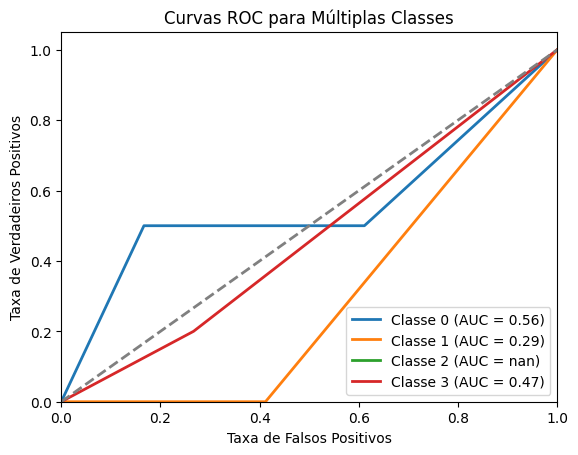

In [ ]:
# Binariação dos rótulos para problemas de múltiplas classes
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Altere a lista de classes conforme o seu caso

# Obter as probabilidades de cada classe para o conjunto de teste
y_prob = knn.predict_proba(X_test)

# Plotar a curva ROC para cada classe
plt.figure()

# Para cada classe
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

# Plotar a linha diagonal (aleatória)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC para Múltiplas Classes')
plt.legend(loc='lower right')
plt.show()